In [1]:
import numpy as np
%config InlineBackend.rc = {}
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.utils.data import download_file

from astropy.io import fits
from matplotlib.colors import PowerNorm

import pylab
import numpy

import os
from os import listdir
from os.path import isfile, join
import glob

In [2]:
def zscale(img, contrast=0.25, samples=500):
    """
    Image scaling function.
    """
    ravel = img.ravel()
    ravel = ravel[np.isfinite(ravel)]

    if len(ravel) > samples:
        imsort = np.sort(np.random.choice(ravel, size=samples))
    else:
        imsort = np.sort(ravel)

    n = len(imsort)
    idx = np.arange(n)

    med = imsort[int(n/2)]
    w = 0.25
    i_lo, i_hi = int((0.5-w)*n), int((0.5+w)*n)
    # BUG: Sometimes the polyfit could fail
    try:
        p = np.polyfit(idx[i_lo:i_hi], imsort[i_lo:i_hi], 1)
        slope, intercept = p
    except Exception:
        slope = 1.0

    z1 = med - (slope/contrast)*(n/2-n*w)
    z2 = med + (slope/contrast)*(n/2-n*w)

    return z1, z2

In [3]:
#organize based on img/bad/sig and galaxy
images = [f for f in listdir('hsc_images/') if isfile(join('hsc_images/', f))]
num_img = len(images)/7
image_2D = [[0]*3 for i in range((int)(len(images)/7))]
i = 0

for image in images:
    if "img" in image:
        image_2D[(int)(i/7)][0] = image
    elif "bad" in image:
        image_2D[(int)(i/7)][1] = image
    elif "sig" in image:
        image_2D[(int)(i/7)][2] = image
    i=i+1     

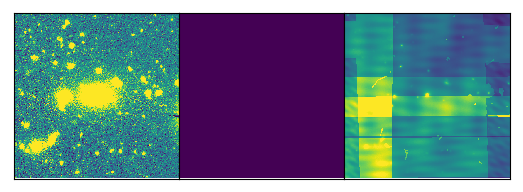

In [4]:
for galaxy in image_2D:
    
    #open and store image data
    img = fits.open('hsc_images/' + galaxy[0])
    img_data = img[0].data[400:800,400:800]
    img.close()
    #open and store sigma data
    sigma = fits.open('hsc_images/' + galaxy[1])
    sigma_data = sigma[0].data[400:800,400:800]
    sigma.close()
    #open and store bad data
    bad = fits.open('hsc_images/' + galaxy[2])
    bad_data = bad[0].data[400:800,400:800]
    bad.close()
    #use def to establish scale for plot
    bd_min,bd_max=zscale(bad_data)
    id_min,id_max=zscale(img_data)
    sd_min,sd_max=zscale(sigma_data)
    #plot
    i = plt.subplot(131)
    if id_min == id_max:
        plt.imshow(img_data,interpolation="none",vmin=id_min,vmax=id_max,origin='lower')
    else:
        plt.imshow(np.arcsinh(img_data),interpolation="none",vmin=id_min,vmax=id_max,origin='lower')
    s = plt.subplot(132)
    if sd_min == sd_max:
        plt.imshow(sigma_data,interpolation="none",vmin=sd_min,vmax=sd_max,origin='lower')
    else: 
        plt.imshow(np.arcsinh(sigma_data),interpolation="none",vmin=sd_min,vmax=sd_max,origin='lower')
    b = plt.subplot(133)
    if bd_min == bd_max:
        plt.imshow(bad_data, interpolation="none",vmin=bd_min,vmax=bd_max,origin='lower')
    else: 
        plt.imshow(bad_data, interpolation="none",vmin=bd_min,vmax=bd_max,origin='lower')

    axes = [ i, s, b ]
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    final_image = plt.subplots_adjust(wspace=0, hspace=0)

    num = galaxy[1][7:10]
    if num[-1:] == '_':
        num = num[:-1]
    pylab.savefig('redadd_'+ num +'_HSC-I_full_concat.png', bbox_inches='tight')